In [1]:
# !pip install torchvision==0.8.1+cpu -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
# !python -m pip install --upgrade pip

In [3]:
# !pip install git+https://github.com/carla-recourse/carla.git

In [4]:
# import sys
# print(sys.executable)

In [6]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [36]:
from carla.data.catalog import CsvCatalog

continuous = ["age", "fnlwgt", "education.num", "capital.gain", "hours.per.week", "capital.loss"]
categorical = ["marital.status", "native.country", "occupation", "race", "relationship", "sex", "workclass"]
immutable = ["age", "sex"]

from carla.data.catalog import OnlineCatalog

# load catalog dataset
data_name = "adult"
dataset = OnlineCatalog(data_name)

display(dataset.df.head())


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income,marital-status_Non-Married,native-country_US,occupation_Other,race_White,relationship_Non-Husband,sex_Male,workclass_Private
0,0.301370,0.044131,0.800000,0.02174,0.0,0.397959,0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
1,0.452055,0.048052,0.800000,0.00000,0.0,0.122449,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.287671,0.137581,0.533333,0.00000,0.0,0.397959,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.493151,0.150486,0.400000,0.00000,0.0,0.397959,0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
4,0.150685,0.220635,0.800000,0.00000,0.0,0.397959,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [86]:
from carla.models.catalog import MLModelCatalog

training_params = {"lr": 0.002, "epochs": 10, "batch_size": 1024, "hidden_size": [18, 9, 3]}

ml_model = MLModelCatalog(
    dataset,
    model_type="ann",
    load_online=False,
    backend="pytorch"
)

ml_model.train(
    learning_rate=training_params["lr"],
    epochs=training_params["epochs"],
    batch_size=training_params["batch_size"],
    hidden_size=training_params["hidden_size"]
)

Loaded model from C:\Users\user\carla\models\adult\ann_layers_18_9_3.pt
test accuracy for model: 0.8416612057667103


c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\carla\models\catalog\ANN_TORCH\model_ann.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


In [87]:
ml_model.predict_proba(ml_model.get_ordered_features(dataset.df))


c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\carla\models\catalog\ANN_TORCH\model_ann.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


array([[0.8606926 , 0.13930735],
       [0.5417038 , 0.45829612],
       [0.987253  , 0.01274693],
       ...,
       [0.3455175 , 0.65448254],
       [0.80009675, 0.19990326],
       [0.34289286, 0.65710706]], dtype=float32)

In [88]:
from carla.models.negative_instances import predict_negative_instances
import carla.recourse_methods.catalog as recourse_catalog

factuals = predict_negative_instances(ml_model, dataset.df)
test_factual = factuals.iloc[:5]

display(test_factual)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income,marital-status_Non-Married,native-country_US,occupation_Other,race_White,relationship_Non-Husband,sex_Male,workclass_Private
0,0.301370,0.044131,0.800000,0.02174,0.0,0.397959,0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
1,0.452055,0.048052,0.800000,0.00000,0.0,0.122449,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.287671,0.137581,0.533333,0.00000,0.0,0.397959,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.493151,0.150486,0.400000,0.00000,0.0,0.397959,0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
4,0.150685,0.220635,0.800000,0.00000,0.0,0.397959,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [25]:
ml_model.predict_proba(ml_model.get_ordered_features(test_factual))


c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\carla\models\catalog\ANN_TORCH\model_ann.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


array([[0.8606926 , 0.13930735],
       [0.5417038 , 0.45829612],
       [0.987253  , 0.01274693],
       [0.84225863, 0.15774141],
       [0.5907896 , 0.40921038]], dtype=float32)

### Actionable Recourse

In [43]:
hyperparams = {"fs_size": 100, "discretize": False, "sample": True}  # possibly increase fs_size -> 500
recourse_method = recourse_catalog.ActionableRecourse(ml_model, hyperparams)
df_cfs = recourse_method.get_counterfactuals(test_factual)


display(df_cfs)

[INFO] Start generating LIME coefficients [model.py get_counterfactuals]
[INFO] Finished generating LIME coefficients [model.py get_counterfactuals]


c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\carla\models\api\mlmodel.py:154: UserWarning: cannot re-order features for non dataframe input: <class 'numpy.ndarray'>
  f"cannot re-order features for non dataframe input: {type(x)}"
c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\carla\models\catalog\ANN_TORCH\model_ann.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)
c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\carla\models\api\mlmodel.py:154: UserWarning: cannot re-order features for non dataframe input: <class 'numpy.ndarray'>
  f"cannot re-order features for non dataframe input: {type(x)}"
c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\carla\models\catalog\ANN_TORCH\model_ann.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as

obtained 100 items in 1.6 seconds


c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\carla\models\api\mlmodel.py:154: UserWarning: cannot re-order features for non dataframe input: <class 'numpy.ndarray'>
  f"cannot re-order features for non dataframe input: {type(x)}"
c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\carla\models\catalog\ANN_TORCH\model_ann.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


obtained 100 items in 1.4 seconds
obtained 100 items in 1.5 seconds
obtained 100 items in 1.4 seconds
obtained 100 items in 1.4 seconds


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Private,marital-status_Non-Married,occupation_Other,relationship_Non-Husband,race_White,sex_Male,native-country_US
0,0.301370,0.044131,0.8,0.02174,0.0,0.397959,0.0,0.0,0.0,1.0,1.0,1.0,1.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.150685,0.220635,0.8,0.00000,0.0,0.397959,0.0,0.0,0.0,1.0,0.0,0.0,0.0


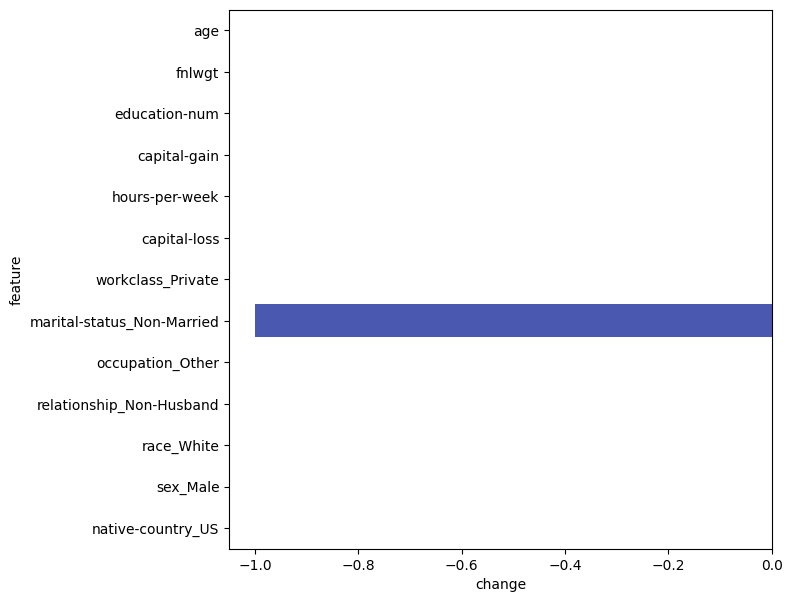

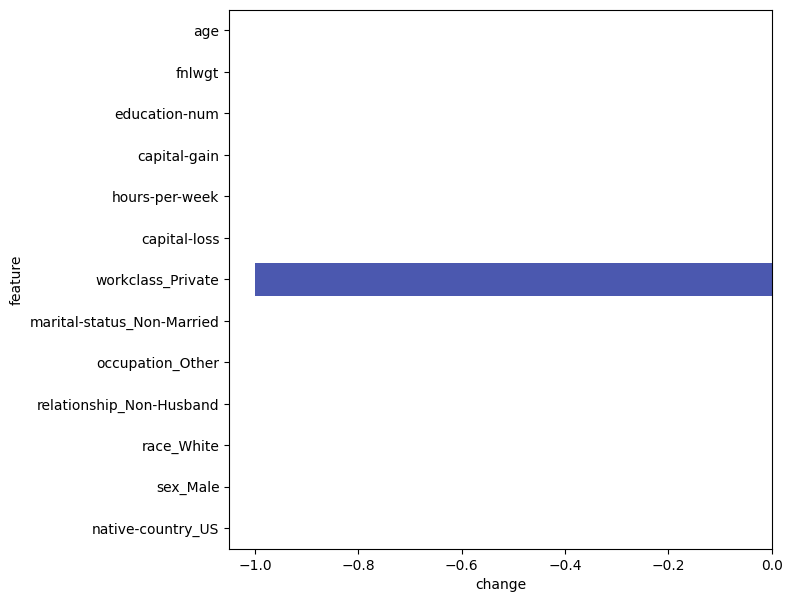

In [44]:
from carla.plotting.plotting import single_sample_plot

df_cfs = df_cfs.dropna()
plt_factuals = test_factual[test_factual.index.isin(df_cfs.index)]


for i in range(len(df_cfs)):
    single_sample_plot(plt_factuals.iloc[i], df_cfs.iloc[i], dataset)

### Casual Recourse

In [28]:
# from carla.data.catalog import CausalAdult

# def constraint_handle():
#     # TO IMPLEMENT
#     return True

In [29]:
# hyperparams = {"optimization_approach": "brute_force", "num_samples": 10, "sample": True}
# recourse_method = recourse_catalog.CausalRecourse(ml_model, hyperparams)
# df_cfs = recourse_method.get_counterfactuals(test_factual)

# display(df_cfs)

### CCHVAE

In [45]:
hyperparams = {
    "data_name": dataset.name,
    "n_search_samples": 100,
    "p_norm": 1,
    "step": 0.1,
    "max_iter": 1000,
    "clamp": True,
    "binary_cat_features": True,
    "vae_params": {
        "layers": [11, 512, 256, 8],
        "train": True,
        "lambda_reg": 1e-6,
        "epochs": 5,
        "lr": 1e-3,
        "batch_size": 32,
    },
}

cchvae = recourse_catalog.CCHVAE(ml_model, hyperparams)
df_cfs = cchvae.get_counterfactuals(test_factual)

display(df_cfs)

[INFO] Start training of Variational Autoencoder... [vae.py fit]
[INFO] [Epoch: 0/5] [objective: 76.135] [vae.py fit]
[INFO] [ELBO train: 76.14] [vae.py fit]
[INFO] [ELBO train: 87.08] [vae.py fit]
[INFO] [ELBO train: 94.32] [vae.py fit]
[INFO] [ELBO train: 101.59] [vae.py fit]
[INFO] [ELBO train: 108.26] [vae.py fit]
[INFO] ... finished training of Variational Autoencoder. [vae.py fit]


c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\carla\models\api\mlmodel.py:154: UserWarning: cannot re-order features for non dataframe input: <class 'torch.Tensor'>
  f"cannot re-order features for non dataframe input: {type(x)}"
c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\carla\models\catalog\ANN_TORCH\model_ann.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Private,marital-status_Non-Married,occupation_Other,relationship_Non-Husband,race_White,sex_Male,native-country_US
0,0.301370,0.104864,0.720221,0.022683,0.056955,0.362167,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,0.452055,0.110309,0.765098,0.024060,0.007395,0.345092,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,0.287671,0.155913,0.652909,0.043531,0.434684,0.385498,1.0,0.0,0.0,1.0,1.0,1.0,1.0
3,0.493151,0.170764,0.565389,0.014556,0.074805,0.354057,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.150685,0.079941,0.769972,0.009855,0.045010,0.359380,0.0,0.0,0.0,1.0,0.0,0.0,0.0


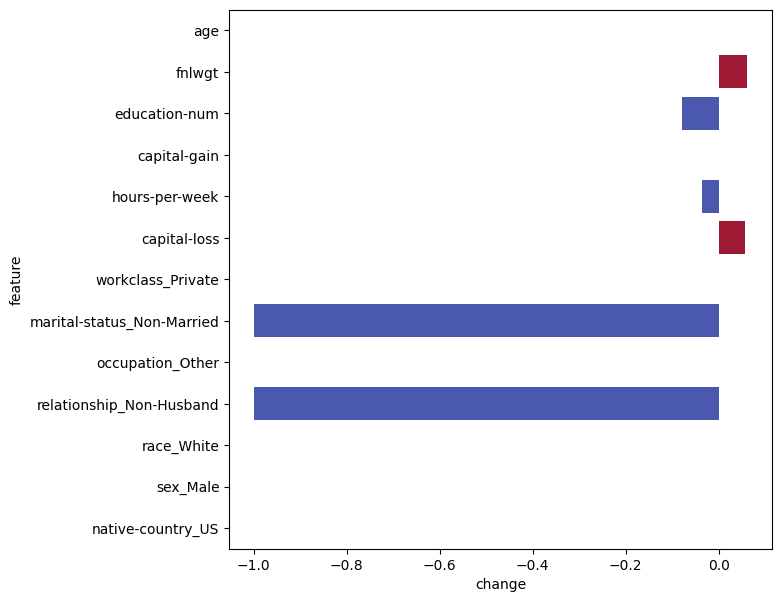

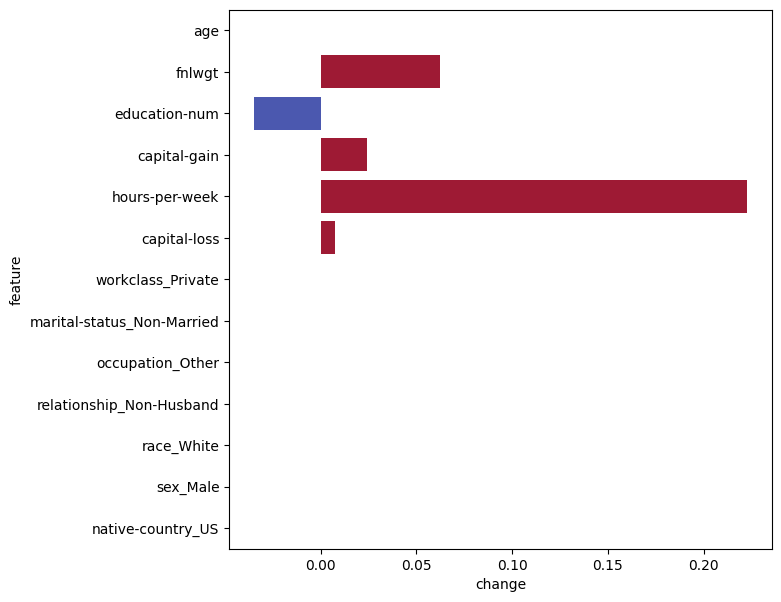

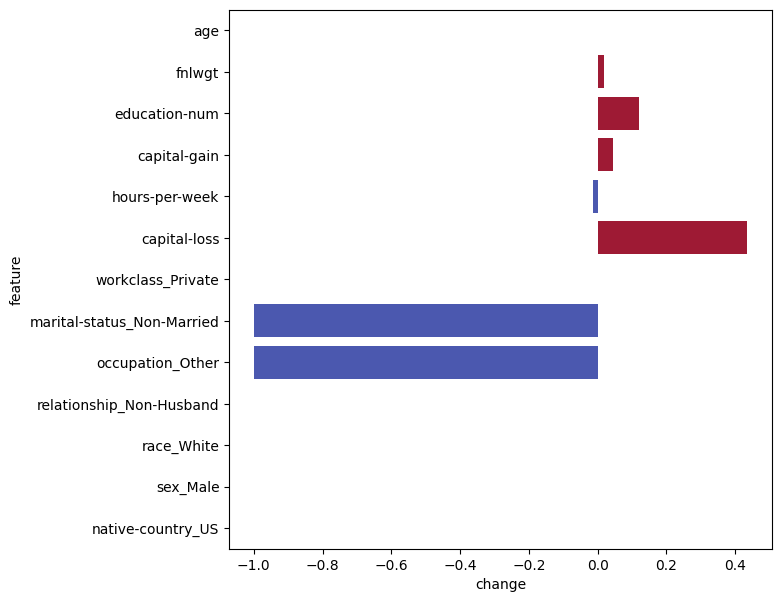

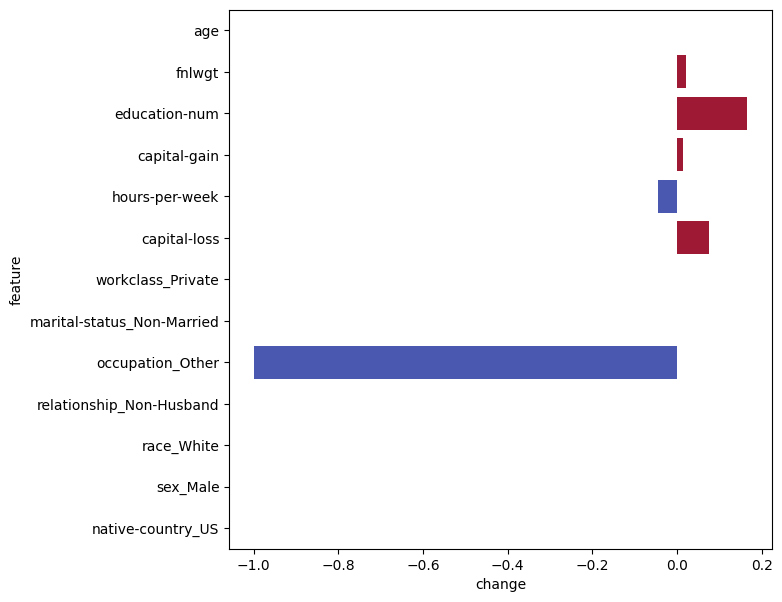

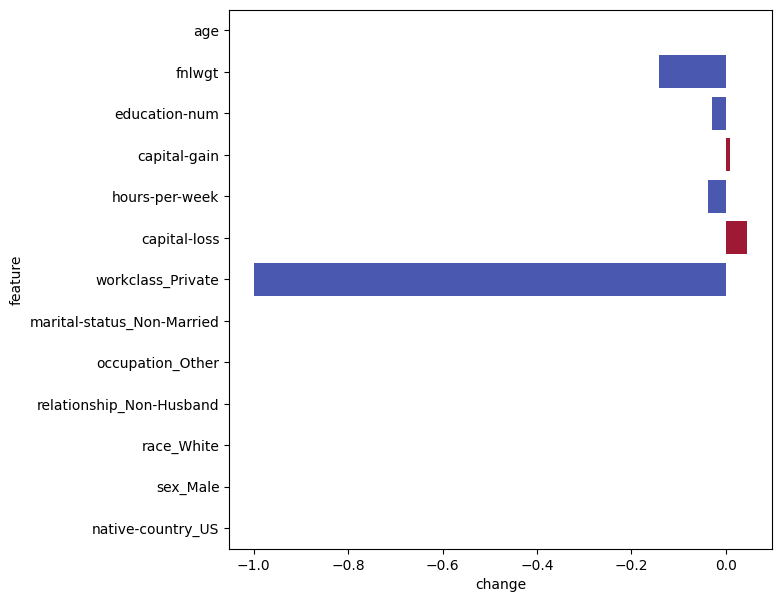

In [47]:
df_cfs = df_cfs.dropna()
plt_factuals = test_factual[test_factual.index.isin(df_cfs.index)]


for i in range(len(df_cfs)):
    single_sample_plot(plt_factuals.iloc[i], df_cfs.iloc[i], dataset)

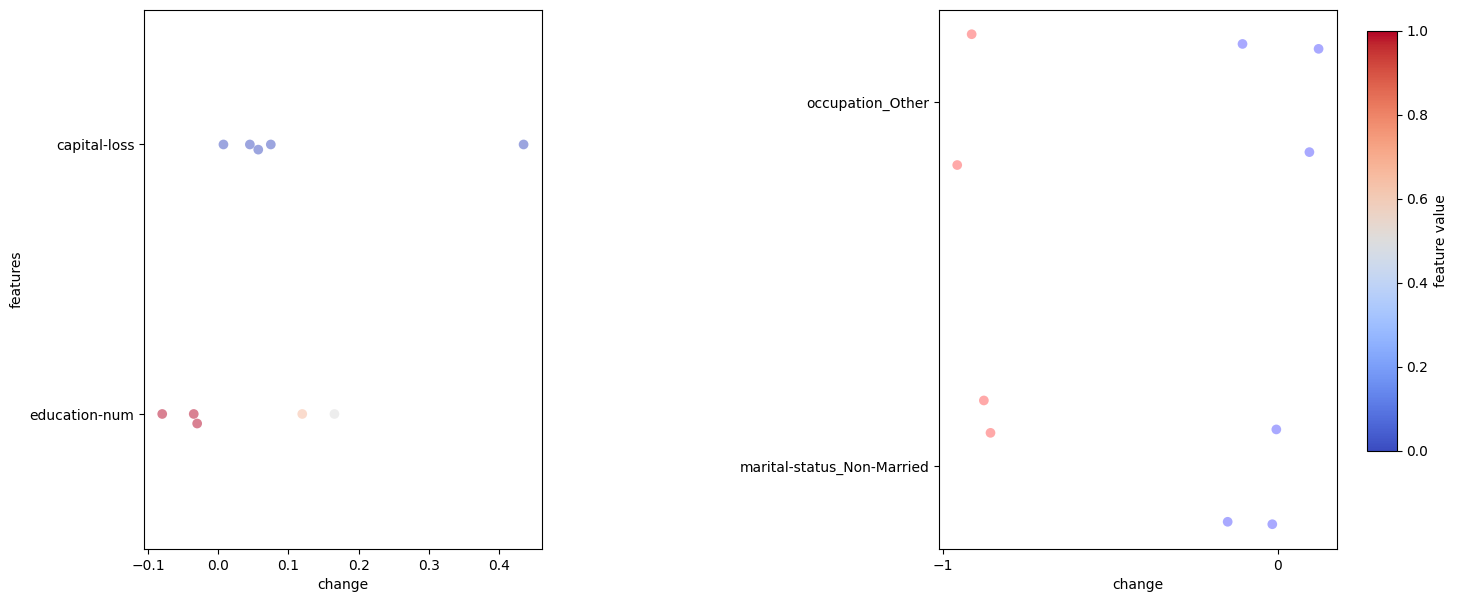

In [49]:
from carla.plotting.plotting import summary_plot

summary_plot(
    plt_factuals,
    df_cfs,
    dataset,
    2)


### Contrastive Explanations Method (CEM)

In [ ]:
ml_model_tf = MLModelCatalog(
    dataset,
    model_type="ann",
    load_online=False,
    backend="tensorflow"
)

ml_model_tf.train(
    learning_rate=training_params["lr"],
    epochs=training_params["epochs"],
    batch_size=training_params["batch_size"],
    hidden_size=training_params["hidden_size"]
)

balance on test set 0.23883245958934032, balance on test set 0.2408256880733945
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 18)                252       
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 171       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 30        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 8         
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________
None
[WARNING] From c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\carla\models\catalog\ANN_TF\model_ann.py:10: The name tf.log is deprecated. Please 

In [67]:
cem_hyperparams = {
    "kappa": 0.1,
    "init_learning_rate": 1e-2,
    "binary_search_steps": 10,
    "max_iterations": 1000,
    "initial_const": 1e-3,
    "beta": 0.1,
    "gamma": 100.0,
    "mode": "PN",  # or "PP" depending on what you want
    "num_classes": 2,
    "data_name": dataset.name,
    "train_ae": True,
    "epochs": 5,
    "ae_params": {
        "hidden_layer": [11, 512, 256, 8],
    }
}

In [68]:
import tensorflow as tf
from carla.recourse_methods.catalog import cem

# Step 1: Start session
sess = tf.compat.v1.Session()

# Step 2: Define or load ml_model and the autoencoder inside cem.CEM
cem_model = cem.CEM(sess, ml_model, cem_hyperparams)

# Step 3: Now initialize *all* variables
sess.run(tf.compat.v1.global_variables_initializer())

# Step 4: Get counterfactuals
df_cfs = cem_model.get_counterfactuals(test_factual)
display(df_cfs)

Train on 34182 samples, validate on 14650 samples
Epoch 1/5
34182/34182 [==============================] - 8s 235us/step - loss: 0.0298 - val_loss: 0.0370
Epoch 2/5
34182/34182 [==============================] - 5s 147us/step - loss: 0.0081 - val_loss: 0.0090
Epoch 3/5
34182/34182 [==============================] - 6s 163us/step - loss: 0.0046 - val_loss: 0.0078
Epoch 4/5
34182/34182 [==============================] - 6s 170us/step - loss: 0.0034 - val_loss: 0.0036
Epoch 5/5
34182/34182 [==============================] - 6s 166us/step - loss: 0.0028 - val_loss: 0.0100


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Private,marital-status_Non-Married,occupation_Other,relationship_Non-Husband,race_White,sex_Male,native-country_US
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.493151,0.50000,0.5,0.500000,0.500000,0.500000,1.0,0.500000,0.000000,0.5,0.500000,0.00000,0.000000
4,0.329044,0.33149,0.8,0.329238,0.328387,0.397959,0.0,0.321753,0.324521,0.0,0.330821,0.32287,0.326175


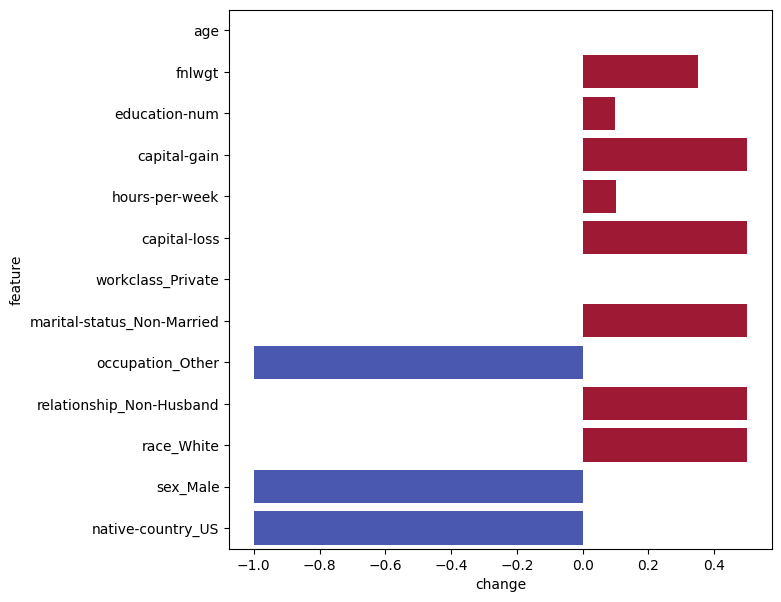

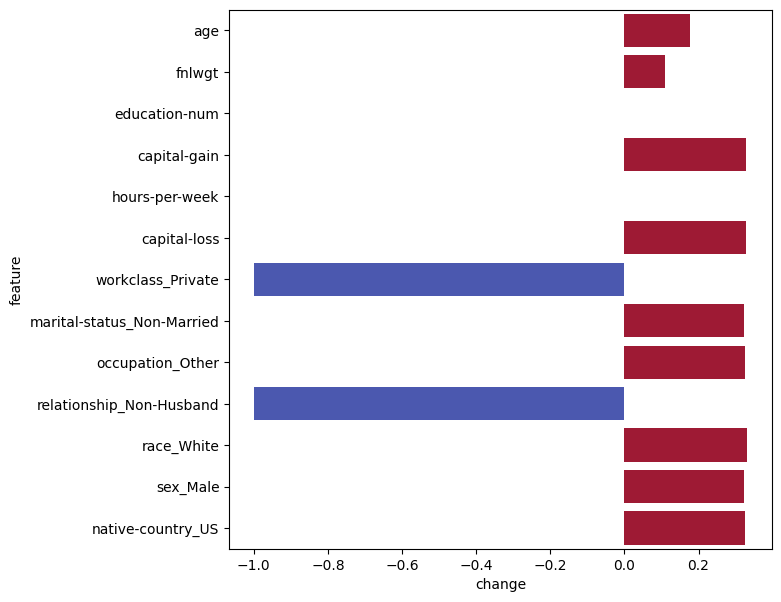

In [69]:
df_cfs = df_cfs.dropna()
plt_factuals = test_factual[test_factual.index.isin(df_cfs.index)]


for i in range(len(df_cfs)):
    single_sample_plot(plt_factuals.iloc[i], df_cfs.iloc[i], dataset)

### Counterfactual Latent Uncertainty Explanations (CLUE)

In [91]:
hyperparams = {
    "data_name": dataset.name,     # e.g., 'adult', 'compas', 'give_me_some_credit'
    "train_vae": True,             # Train VAE from scratch
    "width": 128,                  # Number of neurons per hidden layer
    "depth": 3,                    # Number of hidden layers
    "latent_dim": 10,              # Dimension of the latent space
    "batch_size": 64,              # Batch size for VAE training
    "epochs": 10,                  # Number of epochs for VAE training
    "lr": 1e-3,                    # Learning rate
    "early_stop": 5                # Early stopping patience
}

clue = recourse_catalog.Clue(dataset, ml_model, hyperparams)
df_cfs = clue.get_counterfactuals(test_factual)

display(df_cfs)

[INFO] 
Net: [utils.py __init__]
[INFO] VAE_gauss_net [fc_gauss_cat.py __init__]
[INFO] Total params: 0.08M [fc_gauss_cat.py create_net]
[INFO] 
Network: [train.py train_VAE]
[INFO] 
Train: [train.py train_VAE]
[INFO] init cost variables: [train.py train_VAE]


[INFO] it 0/10, vlb -4.125079,  [train.py train_VAE]
[INFO] time: 18.772434 seconds
 [train.py train_VAE]
[INFO] vlb -1.686521 (-inf)
 [train.py train_VAE]
[INFO] Writting C:\Users\user\carla\models\autoencoders\clue\fc_VAE_adult_models\theta_best.dat
 [utils.py save]
[INFO] it 1/10, vlb -1.644668,  [train.py train_VAE]
[INFO] time: 18.677191 seconds
 [train.py train_VAE]
[INFO] vlb -1.559124 (-1.686521)
 [train.py train_VAE]
[INFO] Writting C:\Users\user\carla\models\autoencoders\clue\fc_VAE_adult_models\theta_best.dat
 [utils.py save]
[INFO] it 2/10, vlb -1.568686,  [train.py train_VAE]
[INFO] time: 18.466853 seconds
 [train.py train_VAE]
[INFO] vlb -1.616219 (-1.559124)
 [train.py train_VAE]
[INFO] it 3/10, vlb -1.530773,  [train.py train_VAE]
[INFO] time: 18.530643 seconds
 [train.py train_VAE]
[INFO] vlb -1.448100 (-1.559124)
 [train.py train_VAE]
[INFO] Writting C:\Users\user\carla\models\autoencoders\clue\fc_VAE_adult_models\theta_best.dat
 [utils.py save]
[INFO] it 4/10, vlb -1

c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\carla\models\api\mlmodel.py:154: UserWarning: cannot re-order features for non dataframe input: <class 'numpy.ndarray'>
  f"cannot re-order features for non dataframe input: {type(x)}"
c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\carla\models\catalog\ANN_TORCH\model_ann.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)
c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\carla\models\api\mlmodel.py:154: UserWarning: cannot re-order features for non dataframe input: <class 'torch.Tensor'>
  f"cannot re-order features for non dataframe input: {type(x)}"


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Private,marital-status_Non-Married,occupation_Other,relationship_Non-Husband,race_White,sex_Male,native-country_US
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
df_cfs = df_cfs.dropna()
plt_factuals = test_factual[test_factual.index.isin(df_cfs.index)]


for i in range(len(df_cfs)):
    single_sample_plot(plt_factuals.iloc[i], df_cfs.iloc[i], dataset)

### Counterfactual Recourse Using Disentangled Subspaces (CRUDS)

In [101]:
hyperparams = {
    "train_vae": True,
    "data_name": dataset.name,       # Important: used to name VAE model
    "width": 20,                # VAE width
    "depth": 3,                 # VAE depth
    "latent_dim": 12,          # VAE latent space size
    "batch_size": 64,
    "epochs": 20,
    "lr": 1e-3,
    "early_stop": 5,
    "lambda_param": 0.1,
    "vae_params": {
        "layers": [11, 512, 256, 8],
        "train": True,
        "lambda_reg": 1e-6,
        "epochs": 2,
        "lr": 1e-3,
        "batch_size": 32,
    },
}

cruds = recourse_catalog.CRUD(ml_model, hyperparams)

[INFO] Start training of CSVAE... [csvae.py fit]


  0%|          | 0/2 [00:00<?, ?it/s]

[INFO] epoch 0: x recon loss: 0.07989849477303294 [csvae.py fit]
[INFO] epoch 0: y recon loss: 22.523336802991313 [csvae.py fit]


 50%|█████     | 1/2 [01:42<01:42, 102.88s/it]

[INFO] epoch 1: x recon loss: 0.07681673630671686 [csvae.py fit]
[INFO] epoch 1: y recon loss: 22.17497524396464 [csvae.py fit]


100%|██████████| 2/2 [03:57<00:00, 118.52s/it]

[INFO] ... finished training of CSVAE [csvae.py fit]


c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\carla\models\api\mlmodel.py:154: UserWarning: cannot re-order features for non dataframe input: <class 'torch.Tensor'>
  f"cannot re-order features for non dataframe input: {type(x)}"
c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\carla\models\catalog\ANN_TORCH\model_ann.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


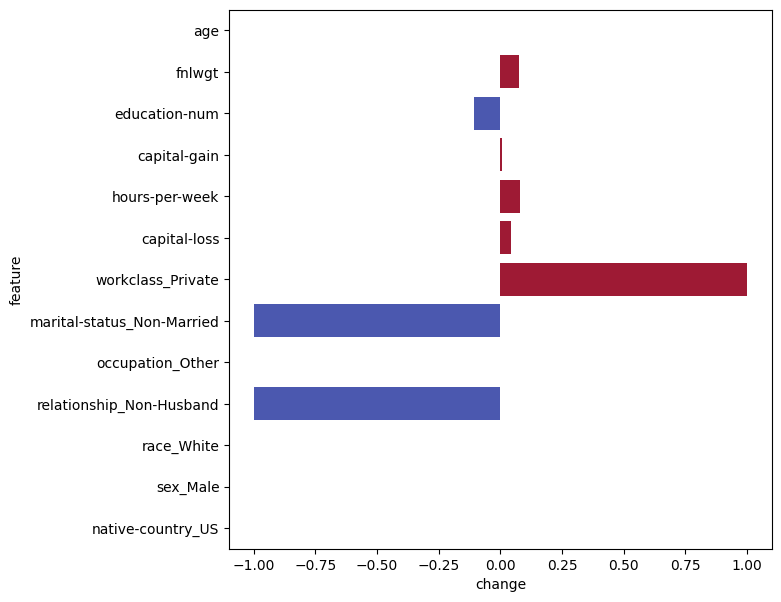

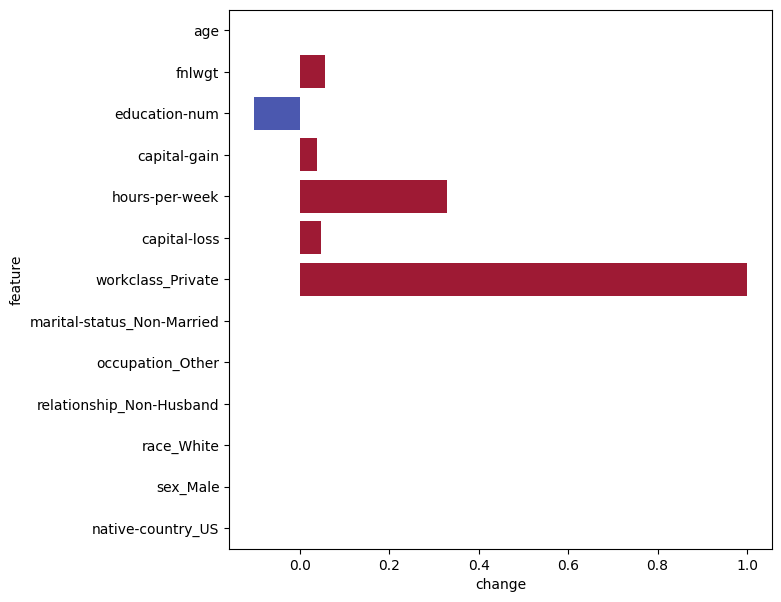

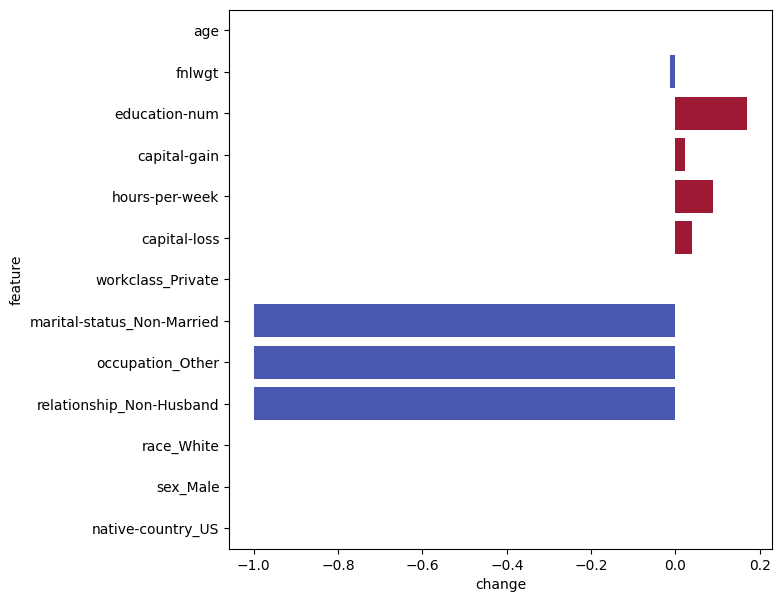

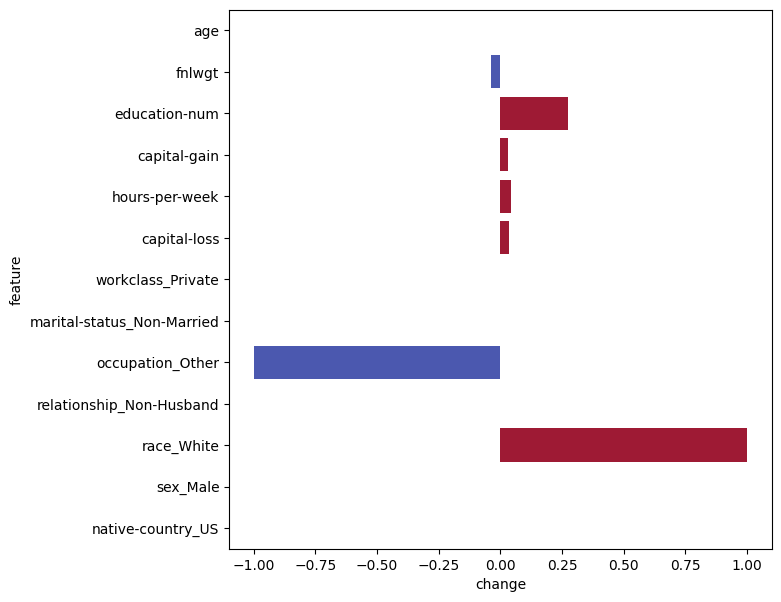

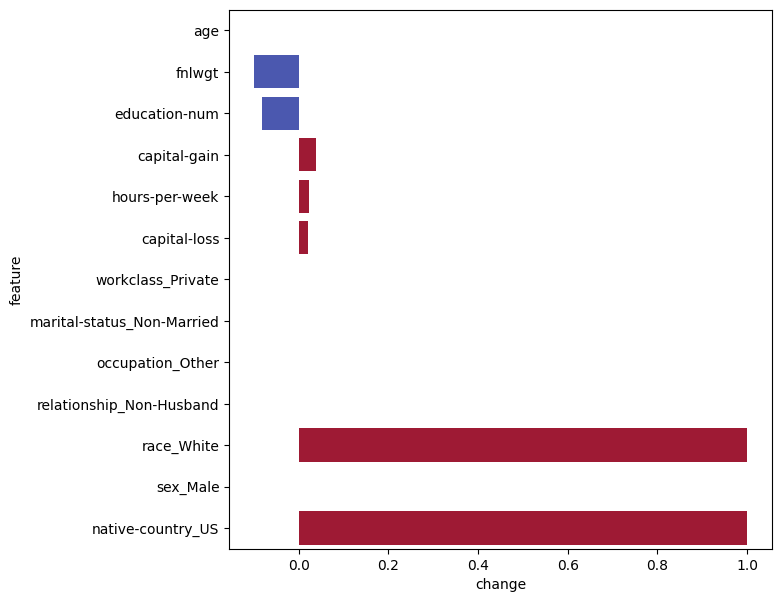

In [102]:
df_cfs = cruds.get_counterfactuals(test_factual)
df_cfs = df_cfs.dropna()
plt_factuals = test_factual[test_factual.index.isin(df_cfs.index)]


for i in range(len(df_cfs)):
    single_sample_plot(plt_factuals.iloc[i], df_cfs.iloc[i], dataset)

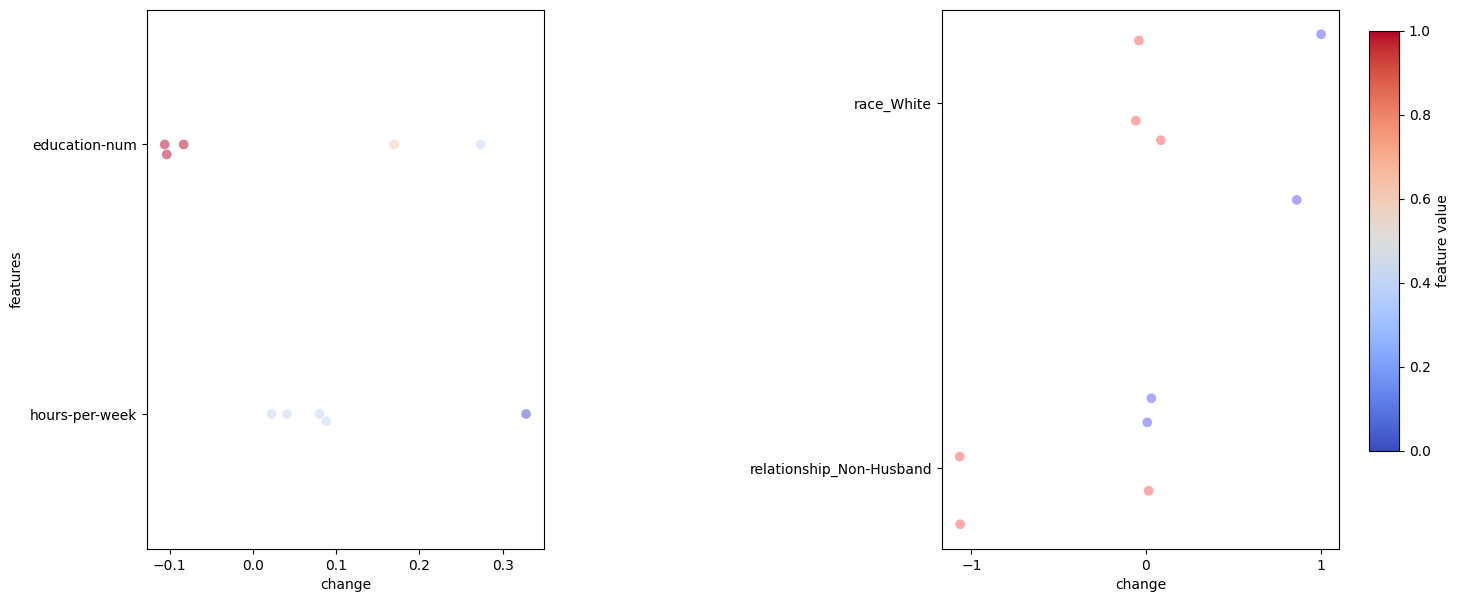

In [103]:
summary_plot(
    plt_factuals,
    df_cfs,
    dataset,
    2)

### Wachter

In [29]:
hyperparams = {"loss_type": "BCE", "binary_cat_features": True}
recourse_method = recourse_catalog.Wachter(ml_model, hyperparams)
df_cfs = recourse_method.get_counterfactuals(test_factual)

display(df_cfs)


[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]


[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]


c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\carla\models\catalog\ANN_TORCH\model_ann.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Private,marital-status_Non-Married,occupation_Other,relationship_Non-Husband,race_White,sex_Male,native-country_US
0,0.350338,0.037074,0.849063,0.070787,0.048886,0.447004,0.0,1.0,0.0,1.0,1.0,1.0,1.0
1,0.472002,0.068002,0.819954,0.019956,0.019952,0.142402,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,0.421715,0.007596,0.667380,0.133881,0.133536,0.532747,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.560466,0.218265,0.468219,0.068162,0.068102,0.466094,1.0,0.0,1.0,0.0,0.0,1.0,1.0
4,0.190070,0.182420,0.839461,0.039425,0.039161,0.437362,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [7]:
ml_model.predict_proba(ml_model.get_ordered_features(df_cfs))


c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\carla\models\catalog\ANN_TORCH\model_ann.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


array([[0.44245315, 0.55754685],
       [0.45485902, 0.545141  ],
       [0.47234362, 0.52765644],
       [0.49689117, 0.50310886],
       [0.45113304, 0.54886705]], dtype=float32)

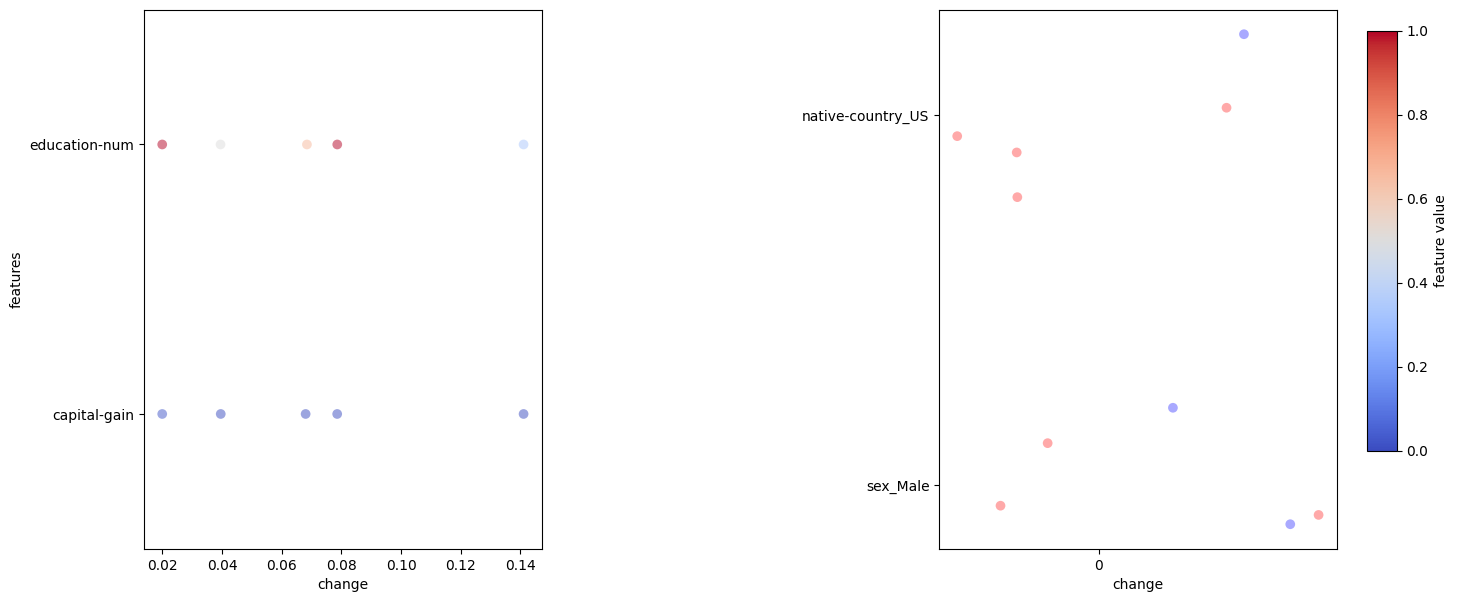

In [ ]:
summary_plot(
    test_factual,
    df_cfs,
    dataset,
    2)


In [9]:
ml_model = MLModelCatalog(dataset, "forest", backend="sklearn", load_online=False)
ml_model.train(max_depth=2, n_estimators=5, force_train=True)

factuals = predict_negative_instances(ml_model, dataset.df)
test_factual = factuals.iloc[:5]

display(test_factual)


balance on test set 0.23883245958934032, balance on test set 0.2408256880733945
model fitted with training score 0.8074759720401922 and test score 0.8088958060288336


,age,fnlwgt,education-num,capital-gain,capital-loss,...,occupation_Other,race_White,relationship_Non-Husband,sex_Male,workclass_Private
0,0.301370,0.044131,0.800000,0.02174,0.0,...,0.0,1.0,1.0,1.0,0.0
1,0.452055,0.048052,0.800000,0.00000,0.0,...,0.0,1.0,0.0,1.0,0.0
2,0.287671,0.137581,0.533333,0.00000,0.0,...,1.0,1.0,1.0,1.0,1.0
3,0.493151,0.150486,0.400000,0.00000,0.0,...,1.0,0.0,0.0,1.0,1.0
4,0.150685,0.220635,0.800000,0.00000,0.0,...,0.0,0.0,1.0,0.0,1.0


In [10]:
from carla import MLModel
import xgboost

class XGBoostModel(MLModel):
    """The default way of implementing XGBoost
    https://xgboost.readthedocs.io/en/latest/python/python_intro.html"""

    def __init__(self, data):
        super().__init__(data)

        # get preprocessed data
        df_train = self.data.df_train
        df_test = self.data.df_test

        x_train = df_train[self.data.continuous]
        y_train = df_train[self.data.target]
        x_test = df_test[self.data.continuous]
        y_test = df_test[self.data.target]

        self._feature_input_order = self.data.continuous

        param = {
            "max_depth": 2,  # determines how deep the tree can go
            "objective": "binary:logistic",  # determines the loss function
            "n_estimators": 5,
        }
        self._mymodel = xgboost.XGBClassifier(**param)
        self._mymodel.fit(
                x_train,
                y_train,
                eval_set=[(x_train, y_train), (x_test, y_test)],
                eval_metric="logloss",
                verbose=True,
            )

    @property
    def feature_input_order(self):
        # List of the feature order the ml model was trained on
        return self._feature_input_order

    @property
    def backend(self):
        # The ML framework the model was trained on
        return "xgboost"

    @property
    def raw_model(self):
        # The black-box model object
        return self._mymodel

    @property
    def tree_iterator(self):
        # make a copy of the trees, else feature names are not saved
        booster_it = [booster for booster in self.raw_model.get_booster()]
        # set the feature names
        for booster in booster_it:
            booster.feature_names = self.feature_input_order
        return booster_it

    # The predict function outputs
    # the continuous prediction of the model
    def predict(self, x):
        return self._mymodel.predict(self.get_ordered_features(x))

    # The predict_proba method outputs
    # the prediction as class probabilities
    def predict_proba(self, x):
        return self._mymodel.predict_proba(self.get_ordered_features(x))


In [11]:
ml_model = XGBoostModel(dataset)

factuals = predict_negative_instances(ml_model, dataset.df)
test_factual = factuals.iloc[:5]

display(test_factual)


[0]	validation_0-logloss:0.58390	validation_1-logloss:0.58336
[1]	validation_0-logloss:0.52318	validation_1-logloss:0.52368


c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-logloss:0.48467	validation_1-logloss:0.48474
[3]	validation_0-logloss:0.45943	validation_1-logloss:0.46031
[4]	validation_0-logloss:0.43972	validation_1-logloss:0.44171


,age,fnlwgt,education-num,capital-gain,capital-loss,...,occupation_Other,race_White,relationship_Non-Husband,sex_Male,workclass_Private
0,0.301370,0.044131,0.800000,0.02174,0.0,...,0.0,1.0,1.0,1.0,0.0
1,0.452055,0.048052,0.800000,0.00000,0.0,...,0.0,1.0,0.0,1.0,0.0
2,0.287671,0.137581,0.533333,0.00000,0.0,...,1.0,1.0,1.0,1.0,1.0
3,0.493151,0.150486,0.400000,0.00000,0.0,...,1.0,0.0,0.0,1.0,1.0
4,0.150685,0.220635,0.800000,0.00000,0.0,...,0.0,0.0,1.0,0.0,1.0


In [12]:
hyperparams = {
    "optimizer": "adam",
    "lr": 0.001,
    "n_class": 2,
    "n_iter": 1000,
    "sigma": 1.0,
    "temperature": 1.0,
    "distance_weight": 0.01,
    "distance_func": "l1",
}

focus = recourse_catalog.FOCUS(ml_model, hyperparams)
df_cfs = focus.get_counterfactuals(test_factual)
display(df_cfs)


[WARNING] From c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\ops\array_ops.py:1354: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where [deprecation.py new_func]
[WARNING] Calling GradientTape.gradient on a persistent tape inside its context is significantly less efficient than calling it outside the context (it causes the gradient ops to be recorded on the tape, leading to increased CPU and memory usage). Only call GradientTape.gradient inside the context if you actually want to trace the gradient in order to compute higher order derivatives. [backprop.py gradient]


c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\carla\models\api\mlmodel.py:154: UserWarning: cannot re-order features for non dataframe input: <class 'numpy.ndarray'>
  f"cannot re-order features for non dataframe input: {type(x)}"
c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\carla\models\api\mlmodel.py:154: UserWarning: cannot re-order features for non dataframe input: <class 'numpy.ndarray'>
  f"cannot re-order features for non dataframe input: {type(x)}"
c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\carla\models\api\mlmodel.py:154: UserWarning: cannot re-order features for non dataframe input: <class 'numpy.ndarray'>
  f"cannot re-order features for non dataframe input: {type(x)}"
c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\carla\models\api\mlmodel.py:154: UserWarning: cannot re-order features for non dataframe input: <class 'numpy.ndarray'>
  f"cannot re-order features for non data

,age,fnlwgt,education-num,capital-gain,hours-per-week,capital-loss
0,0.301374,0.044131,0.799976,0.051016,0.397913,0.0
1,0.452075,0.048052,0.800036,0.051024,0.122492,0.0
2,0.287651,0.137581,0.533279,0.050995,0.397960,0.0
3,0.493151,0.150486,0.400033,0.051015,0.397955,0.0
4,0.150688,0.220635,0.800022,0.050957,0.397977,0.0


In [ ]:
# !pip freeze


absl-py==2.1.0
astor==0.8.1
backcall==0.2.0
carla-recourse @ git+https://github.com/carla-recourse/carla.git@24db00aa8616eb2faedea0d6edf6e307cee9d192
causalgraphicalmodels==0.0.4
cffi==1.15.1
cplex==22.1.0.0
cycler==0.11.0
dataclasses==0.6
debugpy==1.7.0
decorator==5.1.1
dice-ml==0.5
entrypoints==0.4
exceptiongroup==1.2.2
fonttools==4.38.0
future==1.0.0
gast==0.6.0
google-pasta==0.2.0
graphviz==0.20.1
grpcio==1.62.3
h5py==2.10.0
imageio==2.31.2
importlib-metadata==6.7.0
iniconfig==2.0.0
ipykernel==6.16.2
ipython==7.34.0
jedi==0.19.2
Jinja2==3.1.6
joblib==1.3.2
jupyter_client==7.4.9
jupyter_core==4.12.0
Keras==2.3.0
Keras-Applications==1.0.8
Keras-Preprocessing==1.1.2
kiwisolver==1.4.5
lime==0.2.0.1
Markdown==3.4.4
MarkupSafe==2.1.5
matplotlib==3.5.3
matplotlib-inline==0.1.6
mip==1.12.0
nest-asyncio==1.6.0
networkx==2.6.3
numpy==1.19.4
packaging==24.0
pandas==1.1.4
parso==0.8.4
pexpect==4.9.0
pickleshare==0.7.5
Pillow==9.5.0
pluggy==1.2.0
prettytable==3.7.0
prompt_toolkit==3.0.48
protob